# Imports

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

from constants.paths import OUTPUT_DIR
from src.preprocessing import preprocess_data
from src.utils.confusion_matrix import plot_confusion_matrix
from src.utils.cumulative_probability import plot_cumulative_probability
from src.utils.load_data import load_data
from src.utils.plot_roc import plot_roc_curve

import constants.paths as pth

# Load Data

In [2]:
X, y = preprocess_data(load_data())

# Model

In [3]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Train a standard decision tree to create the partitions
tree_partition = DecisionTreeClassifier(
    max_leaf_nodes=8, random_state=42, class_weight="balanced"
)
tree_partition.fit(X_train, y_train)

# Get the leaf id for each training sample
leaf_ids = tree_partition.apply(X_train)
unique_leaves = np.unique(leaf_ids)

# Train a penalized logistic regression model for each leaf
leaf_models = {}
for leaf in unique_leaves:
    # Get data for the current leaf
    X_train_leaf = X_train[leaf_ids == leaf]
    y_train_leaf = y_train[leaf_ids == leaf]

    # Create and train a L2 penalized model
    leaf_model = LogisticRegression(penalty="l2", C=0.1, solver="liblinear")
    leaf_model.fit(X_train_leaf, y_train_leaf)
    leaf_models[leaf] = leaf_model


print(f"Trained {len(leaf_models)} logistic regression models, one for each leaf.")

Trained 8 logistic regression models, one for each leaf.


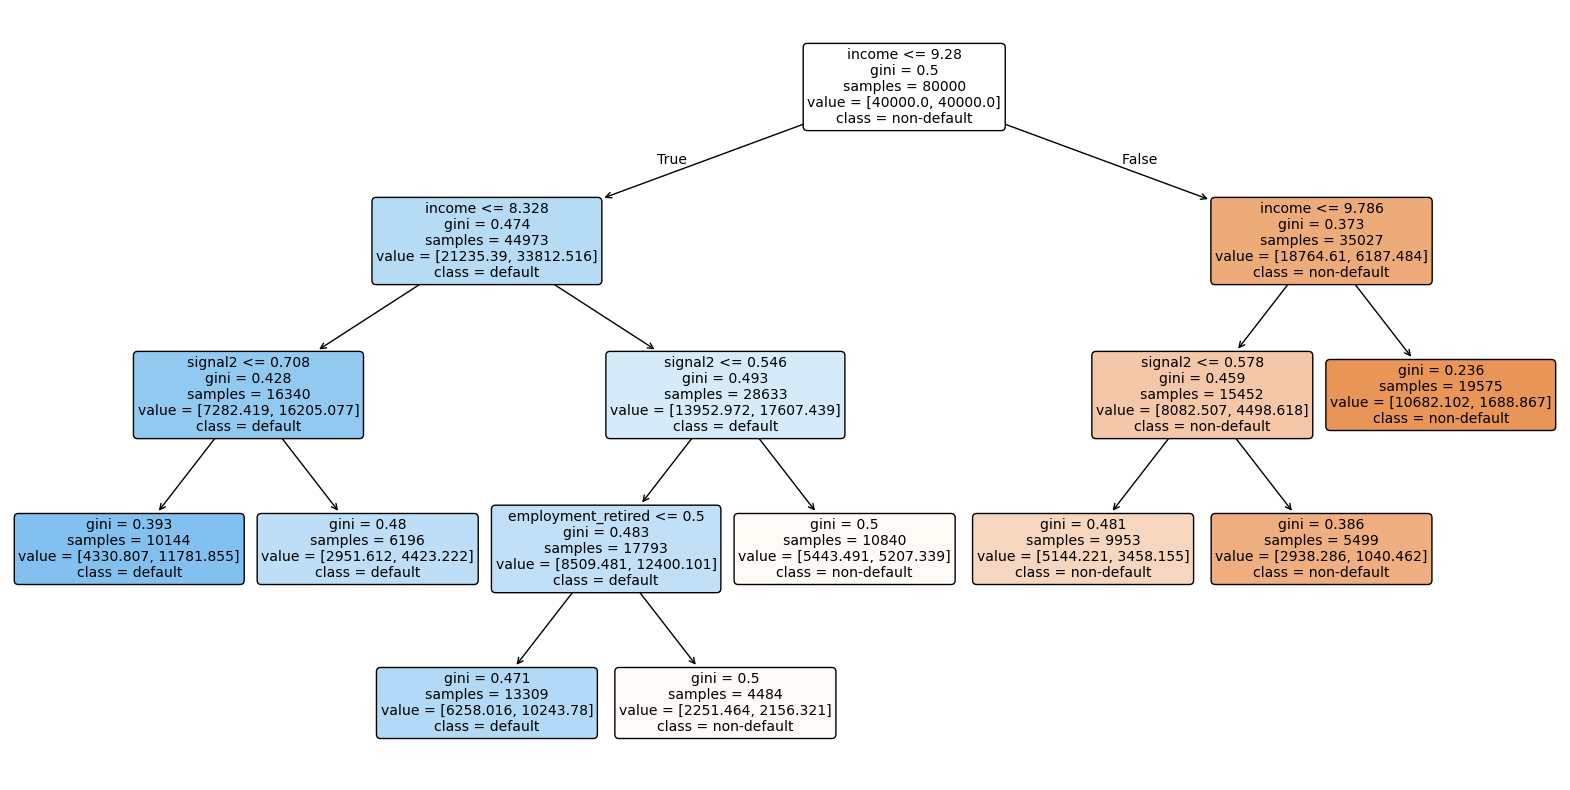

In [5]:
# Create and display the plot
plt.figure(figsize=(20, 10))
plot_tree(
    tree_partition,
    feature_names=X_train.columns,
    class_names=["non-default", "default"],
    filled=True,
    rounded=True,
)
plt.show()

In [6]:
def predict(X_new):
    # Find which leaf each new sample falls into
    new_leaf_ids = tree_partition.apply(X_new)

    # Use the corresponding leaf model to predict
    predictions = np.zeros(len(X_new))
    for leaf, model in leaf_models.items():
        indices = np.where(new_leaf_ids == leaf)[0]
        if len(indices) > 0:
            predictions[indices] = model.predict_proba(X_new.iloc[indices])[:, 1]

    return predictions

In [7]:
y_pred_proba = predict(X_test)

In [8]:
threshold = 0.15
y_pred = (y_pred_proba >= threshold).astype(int)

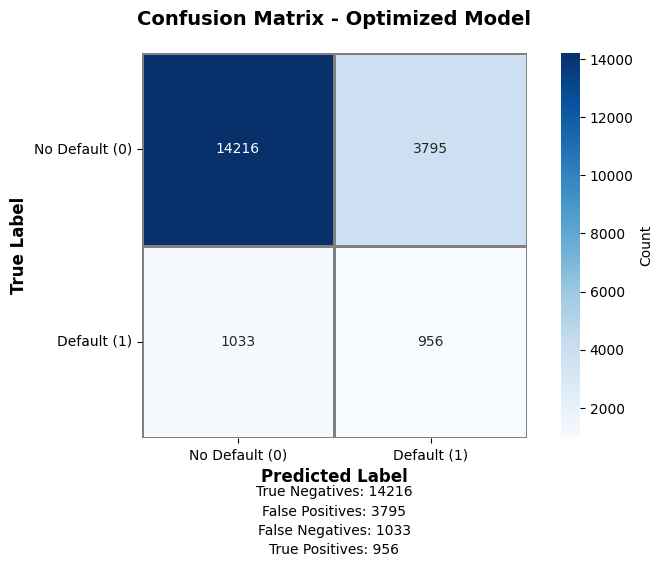


Model Metrics:
Accuracy:  0.7586 (75.86%)
Precision: 0.2012 (20.12%)
Recall:    0.4806 (48.06%)
F1-Score:  0.2837 (28.37%)


In [9]:
plot_confusion_matrix(y_test, y_pred, cmap="Blues")

In [10]:
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"The AUC score is: {auc_score:.4f}")

The AUC score is: 0.7218


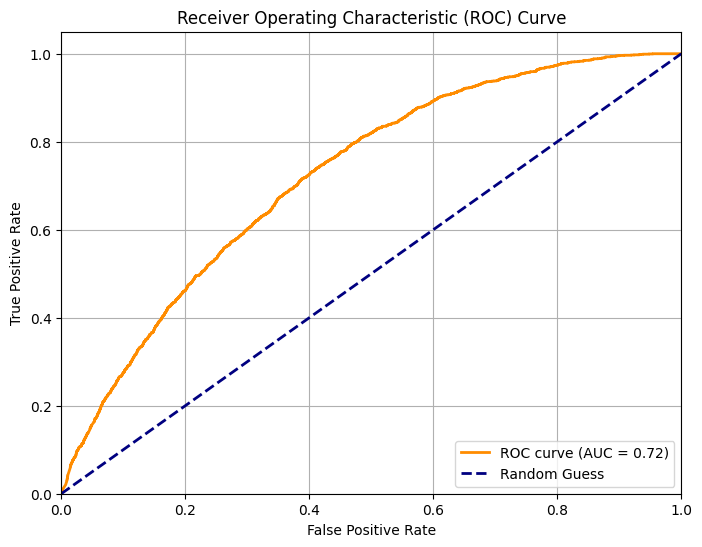

In [11]:
# Call the function with your data
plot_roc_curve(y_test, y_pred_proba)

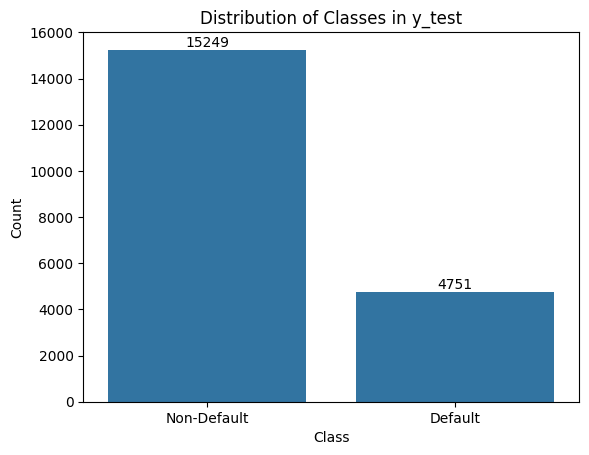

In [12]:
# Assign the plot to an 'ax' variable to access its properties
ax = sns.countplot(x=y_pred)

# Use the bar_label method to add labels
# ax.containers[0] gets the group of bars from the plot
ax.bar_label(ax.containers[0])

ax.set_title("Distribution of Classes in y_test")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_xticks([0, 1], ["Non-Default", "Default"])
plt.show()

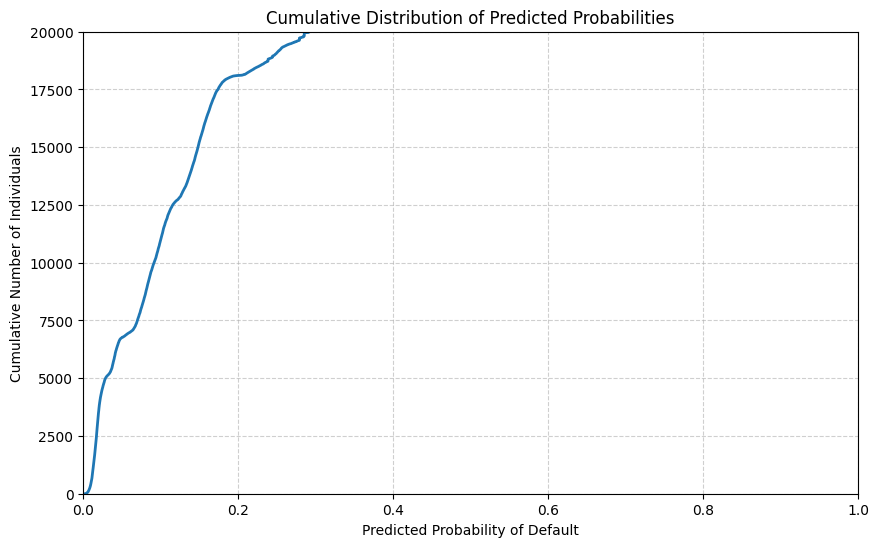

In [13]:
plot_cumulative_probability(y_pred_proba)

# Final predictions

In [8]:
X, y = preprocess_data(load_data())

In [ ]:
# Train a standard decision tree to create the partitions
tree_partition = DecisionTreeClassifier(
    max_leaf_nodes=8, random_state=42, class_weight="balanced"
)
tree_partition.fit(X, y)

# Get the leaf id for each training sample
leaf_ids = tree_partition.apply(X)
unique_leaves = np.unique(leaf_ids)

# Train a penalized logistic regression model for each leaf
leaf_models = {}
for leaf in unique_leaves:
    # Get data for the current leaf
    X_leaf = X[leaf_ids == leaf]
    y_leaf = y[leaf_ids == leaf]

    # Create and train a L2 penalized model
    leaf_model = LogisticRegression(penalty="l2", C=0.1, solver="liblinear")
    leaf_model.fit(X_leaf, y_leaf)
    leaf_models[leaf] = leaf_model


print(f"Trained {len(leaf_models)} logistic regression models, one for each leaf.")

NameError: name 'X_train_leaf' is not defined

In [16]:
quantile_level = 1.0 - 0.175
threshold = np.quantile(y_pred_proba, quantile_level)

In [ ]:
y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=["rate"])

In [27]:
y_pred_proba_df.to_csv(OUTPUT_DIR / "y_pred_proba_PLTR.csv", index=True)